In [193]:
import numpy as np
from matplotlib import pyplot as plt

In [194]:

np.random.seed(2)
X = np.array([[0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 1.75, 2.00, 2.25, 2.50, 
              2.75, 3.00, 3.25, 3.50, 4.00, 4.25, 4.50, 4.75, 5.00, 5.50]])
y = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

X = np.concatenate((np.ones((1, X.shape[1])), X), axis=0)

Hàm sigmoid - Vì sao lại lựa chọn hàm sigmoid?
$$
\sigma(s) = \frac{1}{1 + e^{-s}}
$$
Biến ngẫu nhiên độc lập (hàm gốc):
$$
P(y | X; w) = \prod_{i}^{N} P(y_i | x_i; w) = \prod_{i}^{N} z_i^{y_i} (1 - z_i)^{1-y_i}
$$
Với:
$$
z_i = f(s), s = w^T x
$$
Lấy logarit tự nhiên (log cơ số e), xây dựng Loss Function:
$$
J(w, x_i, y_i) = - \sum_{i}^{N}(y_i \log(z_i) + (1 - y_i) \log(1 - z_i))
$$
Đạo hàm theo w của Loss Fuction:
$$
\nabla _w J = \frac{\partial J}{\partial w} = \frac{\partial J}{\partial z_i} \frac{\partial z_i}{\partial s} \frac{\partial s}{\partial w}
$$
Mà ta có
$$
\frac{\partial J}{\partial z_i} = \frac{z_i - y_i}{(1 - z_i)(z_i)}
$$
và
$$
\frac{\partial s}{\partial w} = x_i
$$
Vậy ta tạo một hàm $z = f(s)$ sao cho:
$$
\frac{\partial z}{\partial s} = (1 - z_i)z_i
$$
Hàm $ f(s) $ ở đây chính hàm hàm sigmoid, bị chặn trong khoảng (0, 1) với đạo hàm:
$$
\frac{\partial \sigma(s)}{\partial s} = \sigma(s) (1 - \sigma(s))
$$
Vậy:
$$
\nabla _w J = (z_i - y_i) x_i
$$

In [195]:
def sigmoid(s):
    return 1 / (1 + np.exp(-s))

def gradient_single(w: np.ndarray, xi: np.ndarray, yi: np.ndarray):
    """
    Đạo hàm từng điểm dữ liệu tại dữ liệu thứ true_i
    s = w^T xi, f(s) = sigmoid(w^T xi)
    """
    return xi.dot((sigmoid(w.T.dot(xi)) - yi).T)

def check_converge(w, epsilon=1e-4):
    """
    Kiểm tra sự hội tụ của w
    """
    return np.linalg.norm(w) / len(w) < epsilon

In [196]:
def logistic_regression_SGD(X, y, w_init, eta):
    """
    Sử dụng thuật toán SGD để hội tụ nhanh hơn
    Cách implement tương tự với bài Gradient Descent phần SGD
    SGD không ổn định, số vòng lặp có thể lên đến vài ngàn.
    """
    w = [w_init]
    w_toCheck = w_init
    N = X.shape[1]
    features = X.shape[0] # number of features
    
    epochs = 10000
    count = 0
    iter_check = 20
    
    for ep in range(epochs):
        permute = np.random.permutation(N)
        for i in range(N):
            count += 1
            true_i = permute[i]
            xi = X[:, true_i].reshape(features, 1)
            yi = y[true_i].reshape(1, 1)
            gradient = gradient_single(w[-1], xi, yi)
            w_next = w[-1] - eta * gradient
            w.append(w_next)
            if count % iter_check == 0:
                if check_converge(w_next - w_toCheck):
                    return w, ep
                w_toCheck = w_next
    return w, ep

$$
\nabla _w J = (z_i - y_i) x_i
$$
Nhắc lại về NAG:
$$
v_t = \gamma v_{t-1} + \eta \nabla_\theta J (\theta - \gamma v_{t-1})
$$

$$
\theta = \theta - v_t
$$

In [197]:
def logistic_regression_nag(X, y, w_init, eta, gamma=.9):
    """
    Sử dụng thuật toán nhìn trước một bước NAG để thuật toán ổn định hơn
    Cách implement giống với phần Gradient Descent phần NAG
    """
    w = [w_init]
    v = np.zeros_like(w_init)
    epochs = 10000
    
    for ep in range(epochs):
        gradient = X.dot((sigmoid((w[-1] - gamma * v).T.dot(X)) - y).T)
        v_next = gamma * v + eta * gradient
        w_next = w[-1] - v_next
        if check_converge(w_next - w[-1]):
            return w, ep
        w.append(w_next)
        v = v_next
        
    return w, ep

In [198]:
features = X.shape[0]
w_init = np.random.randn(features, 1)
w1, ep1 = logistic_regression_nag(X, y, w_init, .01)
print('GD nag: w = ', w1[-1].T, '\n%d iterations' %(ep1+1))
w2, ep2 = logistic_regression_SGD(X, y, w_init, .05)
print('GD SGD: w = ', w2[-1].T, '\n%d iterations' %(ep2+1))

GD nag: w =  [[-4.09698407  1.51117001]] 
85 iterations
GD SGD: w =  [[-4.11386387  1.50545995]] 
3036 iterations


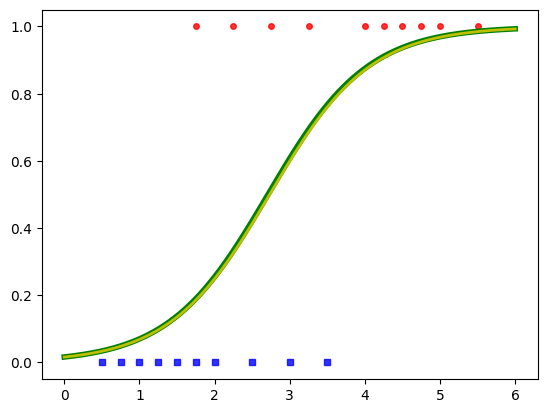

In [199]:
X0 = X[1, np.where(y == 0)][0]
y0 = y[y == 0]
X1 = X[1, np.where(y == 1)][0]
y1 = y[y == 1]

plt.plot(X0, y0, 'bs', markersize=4, alpha=0.8)
plt.plot(X1, y1, 'ro', markersize=4, alpha=0.8)

a1, b1 = w1[-1][0, 0], w1[-1][1, 0]
a2, b2 = w2[-1][0, 0], w2[-1][1, 0]

xs = np.linspace(0, 6, 1000)
f1 = sigmoid(a1 + b1 * xs)
f2 = sigmoid(a2 + b2 * xs)
plt.plot(xs, f1, 'g-', linewidth=4)
plt.plot(xs, f2, 'y-', linewidth=2)
